## Match 30-min MRMS Composite Reflectivity Tracks to 30-min Ensemble Storm Tracks 

### Goal: Determine if a new object ID criteria produces a more skillful prediction of observed storms. 


#### This notebook contains the code for the new object ID criteria. 

In [1]:
from glob import glob
import xarray as xr
import numpy as np
from os.path import join
import os
from WoF_post.wofs.plotting.wofs_colors import WoFSColors
from WoF_post.wofs.plotting.wofs_levels import WoFSLevels
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from skimage.measure import regionprops
from scipy.ndimage import maximum_filter, gaussian_filter, minimum_filter
from scripts import WoFSVerifier, add_contingency_table_compos

import sys
sys.path.append('/home/monte.flora/python_packages/WoF_post')
from monte_python.object_matching import match_to_lsrs, ObjectMatcher
from wofs.verification.lsrs.get_storm_reports import StormReports
from wofs.plotting.util import decompose_file_path

from skexplain.common.multiprocessing_utils import run_parallel, to_iterator

import sys
sys.path.insert(0, '/home/monte.flora/python_packages/MontePython')
import monte_python

%matplotlib inline

In [2]:
def new_id(input_data, remove_low=True):
    
    param_set = [ {'min_thresh': 0,
                   'max_thresh': 100,
                   'data_increment': 1,
                   'delta': 0,
                   'area_threshold': 800,
                   'dist_btw_objects': 125 },
             
             {'min_thresh': 30,
                   'max_thresh': 100,
                   'data_increment': 1,
                   'delta': 0,
                   'area_threshold': 400,
                   'dist_btw_objects': 30 },
                 
              {'min_thresh': 50,
                   'max_thresh': 100,
                   'data_increment': 1,
                   'delta': 0,
                   'area_threshold': 250,
                   'dist_btw_objects': 30 },    
                 
            ]

    params = {'params': param_set }

    # Less than 2/18 = 0.11, 1/18 = 0.055
    new_input_data = np.copy(input_data)
    #if remove_low:
    #    new_input_data[input_data<=0.12] = 0

    new_input_data = maximum_filter(new_input_data, size=4)
    if remove_low:
        new_input_data[input_data<=0.12] = 0
    
    new_input_data = gaussian_filter(new_input_data, 1.5)*100

    storm_labels, new_object_props = monte_python.label(  input_data = new_input_data, 
                       method ='iterative_watershed', 
                       return_object_properties=True, 
                       params = params,  
                       )
    
    # Reduce the object size due to the maximum filter and gaussian filter 
    idx = np.where(input_data==0)
    storm_labels[idx] = 0
    
    #storm_labels = minimum_filter(storm_labels, size=3)
    new_object_props = regionprops(storm_labels, storm_labels)
    
    return storm_labels, new_input_data, new_object_props

## Get the 30-min time-max MRMS composite reflectivity & the 30-min ensemble storm tracks

In [3]:
# MCS case: '20210504 / 2200-0000'
# Isolated case : '20210526', '20210513', '20200507'
# Messy case: '20210517', '20210518'

# ONLY 2021 CASES!!


date = '20210504'
init_time = '2300'
t = 1

dir_name = 'WOFS_2021' if date[:4] == '2021' else 'WoFS_2020'

MRMS_PATH = f'/work/brian.matilla/{dir_name}/MRMS/RAD_AZS_MSH_AGG/'
WOFS_PATH = '/work/mflora/SummaryFiles/'

def get_files(date, init_time, t):
    WOFS_OFFSET = 6 
    MRMS_OFFSET = 18 

    WOFS_PATH = '/work/mflora/SummaryFiles/'
    MRMS_PATH =  f'/work/brian.matilla/{dir_name}/MRMS/RAD_AZS_MSH_AGG/'
    
    wofs_t = t + WOFS_OFFSET
    mrms_t = t + MRMS_OFFSET
    mrms_begin_t =mrms_t - 6 
    try:
        mrms_files = [glob(join(MRMS_PATH, date, init_time, f'wofs_RAD_{tt:02d}*'))[0] for tt in 
                  range(mrms_begin_t, mrms_t+1)]
        wofs_file = glob(join(WOFS_PATH, date, init_time, f'wofs_ENSEMBLETRACKS_{wofs_t:02d}*'))[0]
        return mrms_files, wofs_file
    
    except IndexError:
        return None, None

## Identify tracks in the 30-min time-max MRMS Comp. Refl. 

In [4]:
def identify_mrms_tracks(mrms_files, min_thresh=44):
    """Identify the 30-min MRMS Compo. Refl. Tracks"""
    mrms_dbz = np.max([xr.load_dataset(f)['dz_cress'].values for f in mrms_files], axis=0)
    
    storm_labels, object_props = monte_python.label( input_data = mrms_dbz,
                                   method ='watershed', 
                                   return_object_properties=True, 
                                   params = {'min_thresh': min_thresh,
                                             'max_thresh': 75,
                                             'data_increment': 1,
                                              'area_threshold': 1500,
                                            'dist_btw_objects': 25 } )
    # Quality Control 
    qcer = monte_python.QualityControler()
    qc_params = [('min_area', 12), ('max_thresh', [45, 99])]
    qc_labels, qc_objects_props = qcer.quality_control(mrms_dbz, storm_labels, object_props, qc_params)
    
    return qc_labels, qc_objects_props, mrms_dbz

## Identify new ensemble storm tracks

In [5]:
def get_wofs_tracks(wofs_file, remove_low):
    ds = xr.load_dataset(wofs_file)
    current_tracks = ds['w_up__ensemble_tracks'].values
    probs = ds['w_up__ensemble_probabilities'].values
    new_tracks, new_input_data, new_props = new_id(probs, remove_low)
    current_props = regionprops(current_tracks)
    
    return current_tracks, new_tracks, current_props, new_props, new_input_data, probs

## Match MRMS to the WoFS

In [6]:
def match(current_tracks, new_tracks, mrms_tracks):
    matcher = monte_python.ObjectMatcher(cent_dist_max = 20, 
                                     min_dist_max = 10,
                                     time_max=0, score_thresh=0.2, 
                                     one_to_one = False)

    matched_fcst, matched_obs, _ = matcher.match(ensemble_tracks, qc_labels)
    matched_new_fcst, matched_new_obs, _ = matcher.match(new_labels, qc_labels)

## Match WoFS to LSRs

In [7]:
def reports_to_grid(ncfile):
    """Convert LSRs to gridded data."""
    comps = decompose_file_path(ncfile)
    start_time = comps['VALID_DATE']+comps['VALID_TIME']
    report = StormReports(start_time, 
            forecast_length=30,
            err_window=15,             
            )
    ds = xr.load_dataset(ncfile)
    grid_ds = report.to_grid(dataset=ds)
    lsr_points = report.get_points(dataset=ds)

    return grid_ds, lsr_points 

In [8]:
def match_to_reports(current_tracks, new_tracks, wofs_file):
    grid_ds, lsr_points = reports_to_grid(wofs_file)
    
    target = grid_ds['wind_severe'].values
    
    matcher = monte_python.ObjectMatcher(cent_dist_max = 60, 
                                     min_dist_max = 30,
                                     time_max=0, score_thresh=0.2, 
                                     one_to_one = False, 
                                     match_to_reports=True)

    matched_fcst, matched_obs, _ = matcher.match(current_tracks, target)
    matched_new_fcst, matched_new_obs, _ = matcher.match(new_tracks, target)
    
    return matched_fcst, matched_obs, matched_new_fcst, matched_new_obs, lsr_points, grid_ds

In [9]:
def to_matched_array(labelled_arr, matched_list):
    matched_arr = np.zeros(labelled_arr.shape)
    
    all_labels = np.unique(labelled_arr)[1:]
    for label in all_labels:
        if label in matched_list:
            matched_arr[labelled_arr==label] = 1
        else:
            matched_arr[labelled_arr==label] = -1
    
    matched_arr = np.ma.masked_where(matched_arr==0, matched_arr)
    
    return matched_arr

In [10]:
def missed_reports(matched_reports, report_grid):
    all_reports = np.unique(report_grid)[1:]
    return len(all_reports) - len(matched_reports)

## Contingency Statistics 

In [11]:
min_thresh=45

remove_low = True

mrms_files, wofs_file = get_files(date, init_time, t)
print(wofs_file)

# Load WoFS Data and ID new tracks
current_tracks, new_tracks, current_props, new_props, new_input_data, probs = get_wofs_tracks(wofs_file, 
                                                                                       remove_low=remove_low)
            
# Identify MRMS tracks 
mrms_tracks, mrms_props, mrms_dbz = identify_mrms_tracks(mrms_files, min_thresh=min_thresh)
                
# Match WOFS to MRMS
matcher = monte_python.ObjectMatcher(cent_dist_max = 40, 
                                     min_dist_max = 10,
                                     time_max=0, score_thresh=0.2, 
                                     one_to_one = False)

matched_fcst_current, matched_obs_current, _ = matcher.match(current_tracks, mrms_tracks)
matched_fcst_new, matched_obs_new, _ = matcher.match(new_tracks, mrms_tracks)

matched_arr = to_matched_array(current_tracks, matched_fcst_current)
new_matched_arr = to_matched_array(new_tracks, matched_fcst_new)


# Match WOFS to LSRs
matched_fcst_lsr, matched_obs_lsr, matched_fcst_new_lsr, matched_obs_new_lsr, points, report_grid = match_to_reports(current_tracks, 
                                                                                        new_tracks, wofs_file)

# Calculate number of missed reports. 
N_missed_wind = missed_reports(matched_obs_lsr, report_grid['wind_severe'].values)
N_missed_wind_new = missed_reports(matched_obs_new_lsr, report_grid['wind_severe'].values)


matched_arr_lsr = to_matched_array(current_tracks, matched_fcst_lsr)
new_matched_arr_lsr = to_matched_array(new_tracks, matched_fcst_new_lsr)

/work/mflora/SummaryFiles/20210504/2300/wofs_ENSEMBLETRACKS_07_20210504_2305_2335.nc


In [12]:
def plot_lsrs(ax, points):
    for key in points.keys():
        data = np.array(points[key])
        try:
            ax.scatter(data[:,1], data[:,0], s=10)
        except:
            continue

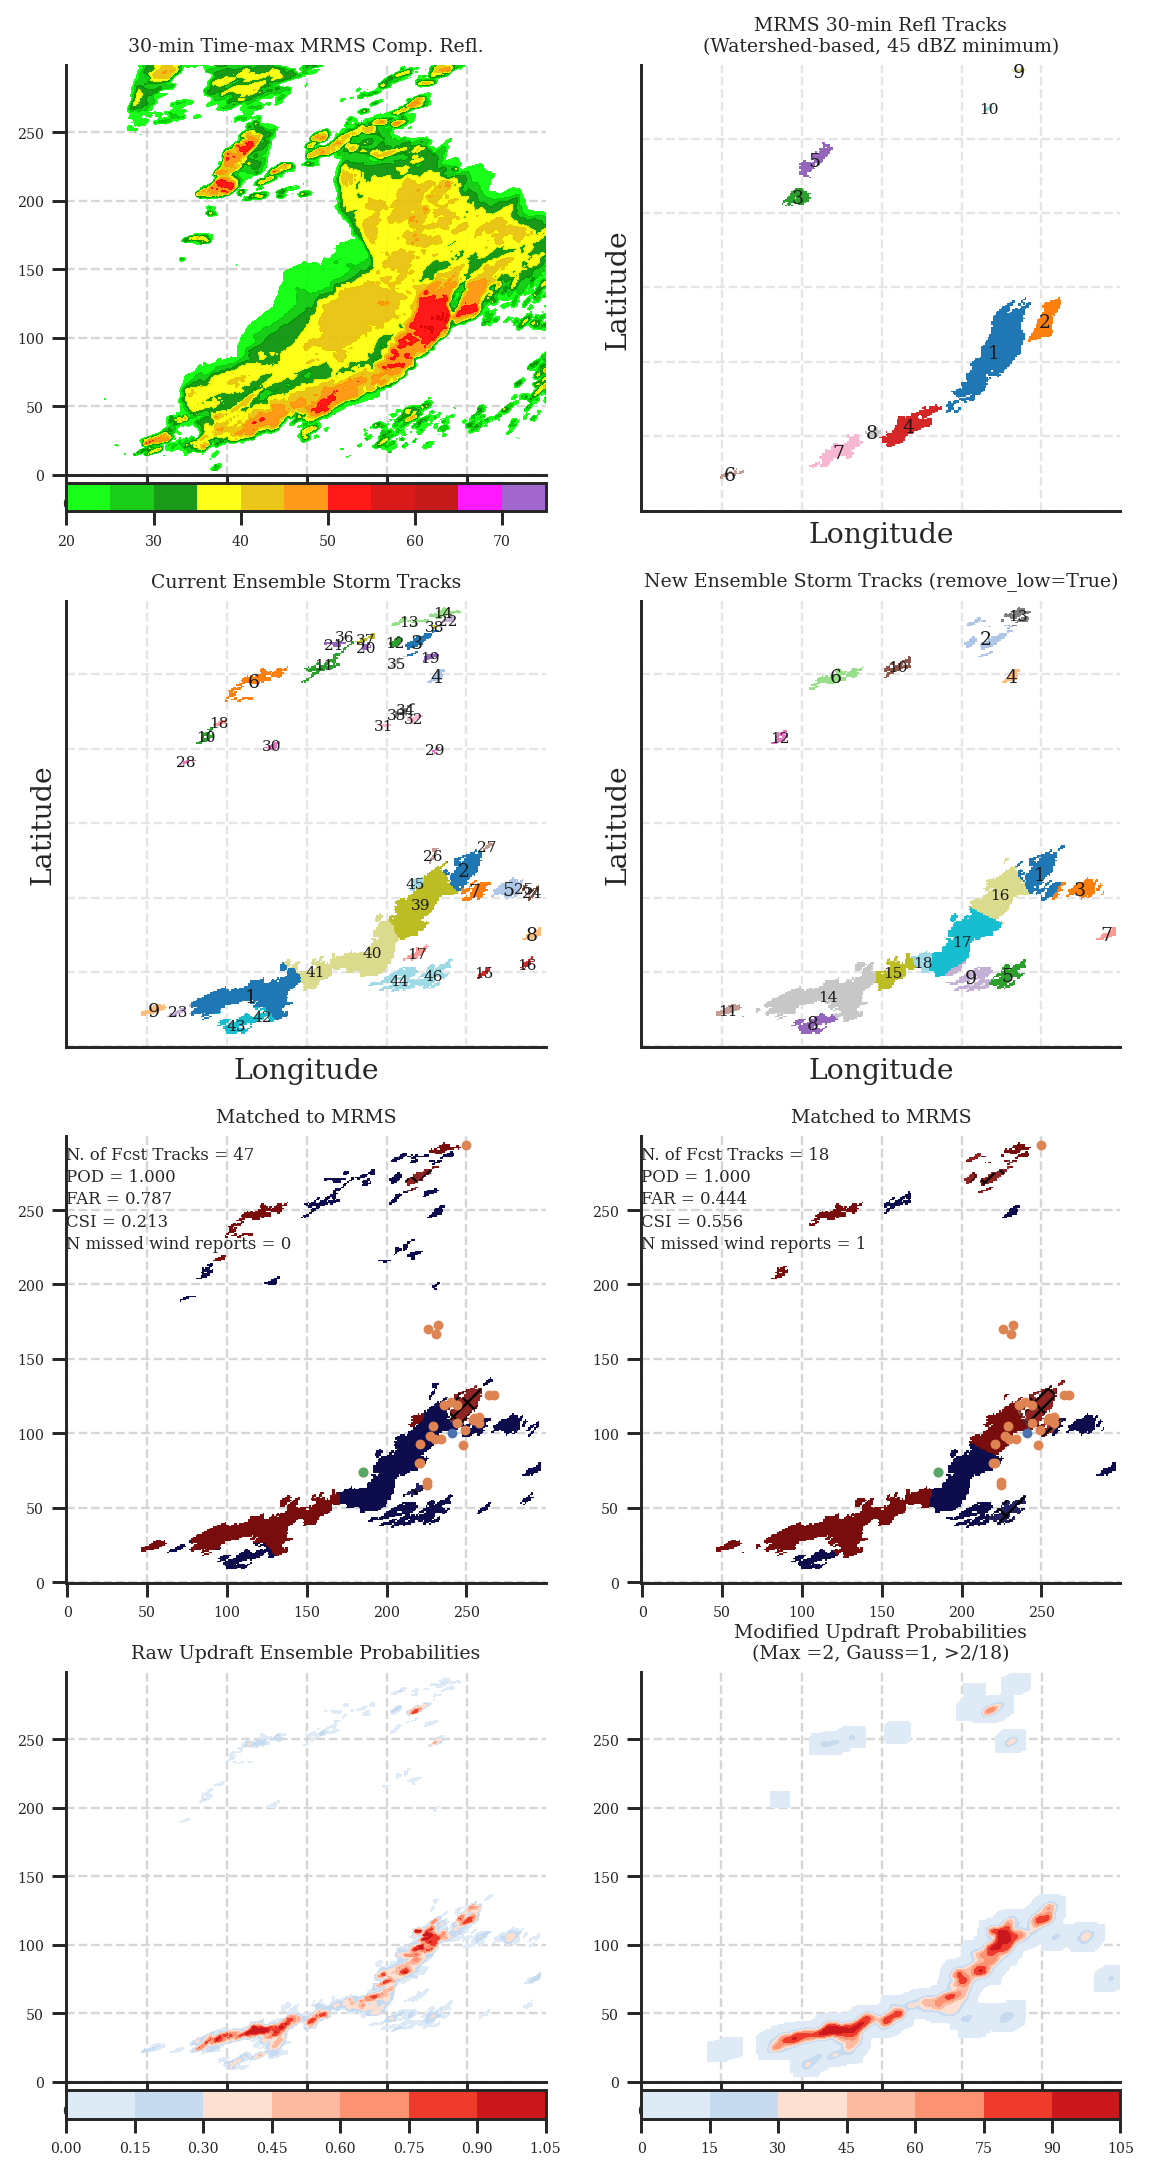

In [13]:
fig, axes = plt.subplots(dpi=170, figsize=(8,16), ncols=2, nrows=4)
ax1_divider = make_axes_locatable(axes[0,0])
ax2_divider = make_axes_locatable(axes[3,0])
ax3_divider = make_axes_locatable(axes[3,1])

# Add an axes to the right of the main axes.
cax1 = ax1_divider.append_axes("bottom", size="7%", pad="2%")
cax2 = ax2_divider.append_axes("bottom", size="7%", pad="2%")
cax3 = ax3_divider.append_axes("bottom", size="7%", pad="2%")

x, y = np.meshgrid(np.arange(len(mrms_dbz)), np.arange(len(mrms_dbz)))
cf = axes[0,0].contourf(x,y,mrms_dbz, cmap=WoFSColors.nws_dz_cmap, 
                 levels = WoFSLevels.dz_levels_nws, alpha=0.9)
axes[0,0].grid(alpha=0.8, ls='dashed')
cb1 = fig.colorbar(cf, cax=cax1, orientation="horizontal")

monte_python.plot_storm_labels(x, y, mrms_tracks, mrms_props, ax=axes[0,1])
monte_python.plot_storm_labels(x, y, current_tracks, current_props, ax=axes[1,0])
monte_python.plot_storm_labels(x, y, new_tracks, new_props, ax=axes[1,1])

#Matched arrays
axes[2,0].pcolormesh(x,y,matched_arr, cmap='seismic', vmin=-1, vmax=1, alpha=0.95)
axes[2,1].pcolormesh(x,y,new_matched_arr, cmap='seismic', vmin=-1, vmax=1, alpha=0.95)

axes[2,0].contourf(x,y,matched_arr_lsr, cmap='gray', vmin=-1, vmax=1, hatches=[None, '////\\\\',], alpha=0.1)
axes[2,1].contourf(x,y,new_matched_arr_lsr, cmap='gray', vmin=-1, vmax=1, hatches=[None, '////\\\\',], alpha=0.1)
plot_lsrs(axes[2,0], points)
plot_lsrs(axes[2,1], points)

verifier = WoFSVerifier()
verifier_new = WoFSVerifier()                     

verifier.add_contingency_table_compos(current_tracks, mrms_tracks, matched_fcst_current, matched_obs_current)
verifier_new.add_contingency_table_compos(new_tracks, mrms_tracks, matched_fcst_new, matched_obs_new)

bot_axes = [axes[2,0], axes[2,1]]

for ax, ver_obj, N_missed in zip(bot_axes, [verifier, verifier_new], [N_missed_wind,N_missed_wind_new]):
    pod, far, csi = ver_obj.get_scores()
    N = ver_obj.hits + ver_obj.false_alarms
    ax.grid(alpha=0.8, ls='dashed')
    txt1 = f'N. of Fcst Tracks = {N}'
    txt2 = f'POD = {pod:.03f}'
    txt3 = f'FAR = {far:.03f}'
    txt4 = f'CSI = {csi:.03f}'
    txt5 = f'N missed wind reports = {N_missed}'
    for i, tx in enumerate([txt1, txt2, txt3, txt4, txt5]):
        ax.annotate(tx, (0,0.95-(i*0.05)), xycoords='axes fraction', fontsize=7)

bot_axes = [axes[3,0], axes[3,1]]
for ax,z,cax in zip(bot_axes, [probs, new_input_data], [cax2, cax3]):
    z = np.ma.masked_where(z==0, z)
    cf = ax.contourf(x,y,z, cmap=WoFSColors.wz_cmap)
    cb1 = fig.colorbar(cf, cax=cax, orientation="horizontal")
    ax.grid(alpha=0.8, ls='dashed')
        
titles = ['30-min Time-max MRMS Comp. Refl.', 
          f'MRMS 30-min Refl Tracks\n(Watershed-based, {min_thresh} dBZ minimum)',
          'Current Ensemble Storm Tracks',
          f'New Ensemble Storm Tracks (remove_low={remove_low})', 
          'Matched to MRMS', 
          'Matched to MRMS',
          'Raw Updraft Ensemble Probabilities',
          'Modified Updraft Probabilities\n(Max =2, Gauss=1, >2/18)'
         ]

for ti, ax in zip(titles, axes.flat):
    ax.set_title(ti)